Feature Scoring Method 
 - f0 - Term Frequency
 - f1- Title word
 - f2- Len/Max Len
 - f3- Position scoring, out of 1
 - f4- Numerical data
 - f5- Proper nouns
 - f6- Pronouns
 - f7- Simm-matrix
 - f8 - Thematic Words
 - f9 - Cue Phrases
 
 ##### for predictions = 100 , F1 Score : 28.8 for stem_1.1@0.3_F1
 ##### for predictions = 1000, F1 score : 29.18  for  stem_1.3@0.7_F1


In [1]:
from os import listdir
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag
import re
import string
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

In [2]:
FINAL_CORPUS = './data/corpus/corpus_cleaned.pkl'
corpus = pd.read_pickle(FINAL_CORPUS)
corpus.sample(3)

,article,summary,article_char_count,article_word_count,article_sentence_count,summary_char_count,summary_word_count,summary_sentence_count
17228,Los Angeles Galaxy star David Beckham will be ...,"Superstar David Beckham leaving L.A. Galaxy, d...",1937,341,16,211,30,3
13546,Marco Rubio is writing his life story. Now the...,"Ruben Navarrette: GOP ""rock star"" Marco Rubio ...",5802,1030,59,350,60,4
70411,WASHINGTON -- Veteran Pennsylvania Sen. Arle...,Pennsylvania Republican has been in the Senate...,7886,1296,68,240,36,4


In [3]:
PUNCTUATION_STOP = ['"', "'", '', '...', '!', '?', '(', ')', '[', ']', '{', '}', '\\', '/', ':', ',', '...',
               '$', '#', '%', '*', '%', '$', '#', '@', '--', '-', '_', '+', '=', '^', "''", '""', '','those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve']


In [4]:

# Remove  punctuation/stopwords
def tokens_without_punctuation(text):
    tokens = word_tokenize(text)

    no_punctuation=[]
    for x in tokens:
        if x not in PUNCTUATION_STOP:
            no_punctuation.append(x)
    return no_punctuation

# Separates text into sentences
def  sentence_tokenize(text):
     sentence_tokenized = list()
     for txt in text.split('\n'):
          sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized

# words_list: list of words to be tokenized
# tokenizer: (string) can be 'lemma' or 'stem'
def _create_list_of_tokens(words_list, tokenizer):

     if tokenizer == 'lemma':
          token_maker = lambda word: WordNetLemmatizer().lemmatize(word).lower()
     else:
          token_maker = lambda word: PorterStemmer().stem(word).lower()
     token_list = list()

     for word in words_list:
          token = token_maker(word)
          if token not in PUNCTUATION_STOP:
               token_list.append(token)
     return token_list

 
def _create_dictionary_table(text, tokenizer = 'stem'):
  
    # Words tokenized => Not Stem/Leema Yet
    words_list = tokens_without_punctuation(text)

    # Tokens stemmed/lemmitized
    token_list = _create_list_of_tokens(words_list, tokenizer)

    # list of n-grams 
    # n_gram_list = _create_list_of_ngrams(token_list, n_gram)

    # dictionary to count the frequency of n-grams
    frequency_table = dict()

    for token in token_list:  
          if token in frequency_table:
              frequency_table[token] += 1
          else:
              frequency_table[token] = 1
    
    return frequency_table





In [5]:
def listToString(s):     
        str1 = " "  
        return (str1.join(s))


def preprocessing (text,tokenizer):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    # print(tokens)
    
    stripped=[]
    for x in tokens:
        if x not in PUNCTUATION_STOP:
            stripped.append(x)
    # print(stripped[:100])

    if tokenizer == 'lemma':
        token_list=[WordNetLemmatizer().lemmatize(word) for word in stripped]
    else:    
        porter = PorterStemmer()
        token_list = [porter.stem(word) for word in stripped]

    # print(stemmed[:100])

    return(listToString(token_list))

In [6]:
def  sentence_tokenize(contents):
     sentence_tokenized = []
     for txt in contents.split('.'):
          if txt!="" or " ":
               sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized


In [7]:
def feature0(sentences,senno, frequency_table) -> dict:   

    sentence_weight = dict()
    
    for sentence in sentences:
        words_list = tokens_without_punctuation(sentence)
        token_list = _create_list_of_tokens(words_list,"lemma")
        count=0
        
        for token in token_list:
            count+=1
            if token in frequency_table:
                if sentence in sentence_weight:
                    sentence_weight[sentence] += frequency_table[token]
                else:
                    sentence_weight[sentence] = frequency_table[token]
        
        if sentence in sentence_weight and sentence_weight[sentence] > 0:
          sentence_weight[sentence] = sentence_weight[sentence] / count
        else:
          sentence_weight[sentence] = 0
    return sentence_weight

In [8]:
# Title Words Similarity

def feature1(titlewords,sentences,senno):
    f1=[0]
    for i in range (0,senno-1):
        f1.append(0)

    for i in range (0,senno):
        sentences[i]=sentences[i].split(" ")
        
    for i in range (0,senno):    
        for wordtemp in sentences[i]:
            if wordtemp in titlewords:
                f1[i]=f1[i]+1;
        f1[i]=f1[i]/len(titlewords)
    return f1


In [9]:
def feature8(thematic_words,sentences,senno):
    f8=[0]
    for i in range (0,senno-1):
        f8.append(0)

    for i in range (0,senno):
        sentences[i]=sentences[i].split(" ")
        
    for i in range (0,senno):    
        for wordtemp in sentences[i]:
            if wordtemp in thematic_words:
                f8[i]=f8[i]+1;
        f8[i]=f8[i]/len(thematic_words)
    return f8

In [10]:

#Normalised length calculation
def feature2(sentences,senno):
    max=0
    for i in sentences:
        if len(i)>max:
            max=len(i)

    f2=[0]
    for i in range (0,senno-1):
        f2.append(0)
    
    for i in range(0, senno):
        f2[i]=float(len(sentences[i])/max)
    return f2


In [11]:
# Sentence Position

def feature3(sentences, senno):
    f3=[0]
    for i in range (0,senno-1):
        f3.append(0)
    for i in range(0, senno):
        f3[i]=(senno-i)/senno
    return f3

In [12]:

#Numerical data

def feature4(sentences,senno):
    f4=[0]
    for i in range(0, senno-1):
        f4.append(0)
    for i in range(0, senno):
        for word in sentences[i]:
            for char in word:
                if(char.isdigit()):
                    f4[i]=f4[i]+1
        f4[i]= f4[i]/len(sentences[i])   
    return f4


In [13]:
# Proper Noun

def feature5(sentences2,senno):
        f5=[0]
        for i in range(0,senno-1):
                f5.append(0)
        max=0
        for i in range(0,senno):
                sentence=sentences2[i]
                tagged_sent = pos_tag(sentence.split())
                propernouns = [word for word, pos in tagged_sent if pos == 'NNP']
                f5[i]= len(propernouns)/len(sentence.split())
        return f5

In [14]:
# Pronouns

def feature6(sentences2,senno):
        f6=[0]
        for i in range(0,senno-1):
                f6.append(0)
        for i in range(0,senno):
                sentence=sentences2[i]
                tagged_sent = pos_tag(sentence.split())
                pronouns = [word for word, pos in tagged_sent if (pos == 'PRP$' or pos=='PRP')]
                f6[i]= len(pronouns)/len(sentence.split())
                
        return f6

In [15]:
# Similarity matrix

def feature7(sentences, senno):
    simmat=[[0]*senno for x in range(senno)]
    
    for i in range(0,senno):
        for j in range(i+1,senno):
            #print(i,j)
            for word in sentences[j]:      
                if word in sentences[i]:
   
                    simmat[i][j]=simmat[i][j]+1
                    simmat[j][i]=simmat[i][j]         
    return simmat


In [16]:
cue_phrases = [
    "For example,",
    "For instance,",
    "In particular,",
    "Specifically,",
    "To illustrate,",
    "In other words,",
    "That is,",
    "Namely,",
    "As an illustration,",
    "In particular,",
    "Especially,",
    "Notably,",
    "However,",
    "On the other hand,",
    "In contrast,",
    "Nevertheless,",
    "Nonetheless,",
    "Conversely,",
    "Similarly,",
    "Likewise,",
    "In the same way,",
    "Also,",
    "Moreover,",
    "Furthermore,",
    "Additionally,",
    "Besides,",
    "In addition,",
    "Above all,",
    "First,",
    "Second,",
    "Third,",
    "Finally,",
    "Last but not least,"
]

# Cue Phrases Matching
def feature9(sentences):
    list_1=sentences

    list_2=cue_phrases
    count_dict={}
    for l in list_1:
        c=0
        for l2 in list_2:     
            if l.find(l2)!=-1:
                c=1
                break           
        if c:#
            count_dict[l]=1
        else:
            count_dict[l]=0

    return count_dict

In [17]:
def _calculate_sentence_scores(sentences, senno, f0,f1,f2,f3,f4,f5,f6,f7,f9):
    
    scores=[]
    # print("calculating scores")
    score=0
    for i in range(0,senno):
            score=f0[i]+f1[i]+f2[i]+f3[i]+f4[i]+f5[i]+f6[i]+f7[i]+f9[i]
            scores.append(score)
    # print(scores)
    return scores

    
  
 

def _calculate_average_score(sentences,senno,scores) -> int:
    avg_score=0
    for i in range(0, senno):
        avg_score +=scores[i]/senno

        # print(scores[i]," : ",sentences[i])  
   
    return avg_score

def _get_article_summary(sentences2, scores,senno,average_score,f2,f7,threshold_factor,sim_tol=0.8):

    threshold_factor=(threshold_factor * average_score)
    # print("Threshold : " ,threshold_factor )

    # print("Tolerance f7 : " ,sim_tol )
    
    sum1=[]
    sum1.append(0)

    for i in range(0, senno):
        if scores[i]>=threshold_factor:         
            if i not in sum1:
                sum1.append(i) 
    
    #removing too short sentences according to feature2
    for i in range(0,senno):
        if f2[i]<0.5:
            if i in sum1 and i!=0:
                sum1.remove(i)

    #removing repeated or very similar sentences
    #increase number to decrease tolerance for similarity
    for i in range(1, senno):
        if f7[i]>sim_tol:
            if i in sum1 and i!=0:
                sum1.remove(i)      
   
    sum1.sort() 
    summary=""

    # print("Sentences Selected : ",len(sum1))

    for i in sum1:
        # print (i) 
        # print((sentences2[i]).strip("\n")) #prints sentences chosen for summary
        summary+=sentences2[i]+"."

    return summary


def run_article_summary(article, tokenizer="lemma",threshold_factor=1,sim_tol=0.7):
    contents=preprocessing(article,tokenizer)

    orig_sentences=sentence_tokenize(article)
    sentences = sentence_tokenize(contents)
    senno=len(sentences)
    frequency_table={}
    frequency_table = _create_dictionary_table(contents)
   
    # print(my_list)

    sorted_freq_table=sorted(frequency_table.items(),key=lambda x:x[1])
    # print(sorted_freq_table)

    thematic_words=[]
    for x in list(reversed(list(sorted_freq_table)))[0:5]:
        # print (x[0])
        thematic_words.append(str(x[0]))

    # print(thematic_words)

    # print("Sentences : ",sentences)

    # print("No of sentences : ",senno)



    f0_dict=feature0(sentences,senno,frequency_table)
    f0=[0]
    for i in range (0,senno-1):
        f0.append(0)
    # f0 =[i for i in f0_dict.values()]
    # print("F0",len(f0),f0)

    cue_match=feature9(orig_sentences)
    # print(cue_match)
    f9=[0]
    for i in range (0,senno-1):
        f9.append(0)
    # f9=list(cue_match.values())
    # print("Feature F9",len(f9),f9)


    title= sentences[0]
    title=title.rstrip(".")
    titlewords= title.split(" ")

    # print("Title : ",title)
    # print("Title Words : ",titlewords)

    f1=feature1(titlewords, sentences, senno)
    # print("F1 Title word ",len(f1),f1)

    # f8=feature8(thematic_words,sentences,senno)

    f2=feature2(sentences,senno)
    # print("F2 Len/Max Len",len(f2),f2)
    f3=feature3(sentences, senno)
    # print("F3 Position scoring",len(f3),f3)
    f4=feature4(sentences,senno)
    # print("F4 Numerical data",len(f4),f4)


    sentences2= sentence_tokenize(article)
    
    f5=feature5(sentences2, senno)
    # print("F5 Proper nouns",len(f5),f5)
    f6=feature6(sentences2, senno)
    # print("F6 Pronouns",len(f6),f6)

    simmat=feature7(sentences, senno)

    #defuzzification for similarity matrix
    f7=[]
    for i in range(0,senno):
        f7.append(0)
    
    for i in range(0,senno):
        m= max(simmat[i])
        m=m/len(sentences[i])
        f7[i]=m
    # print("F7 Simm-matrix",len(f7),f7)

    
    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, senno,f0, f1,f2,f3,f4,f5,f6,f7,f9)
    # print("Sentence Scores : ",sentence_scores)

    average_score = _calculate_average_score(sentences,senno,sentence_scores)
    # print("Average Score : ",average_score)

    #producing the summary wrt threshold*average_score
    article_summary = _get_article_summary(sentences2, sentence_scores,senno,average_score,f2,f7,threshold_factor,sim_tol)

    return article_summary



In [38]:
my_dict = {'A': 300,'B': 150, 'C': 500, 'D': 850, 'E': 400}

my_list = [i for i in my_dict.values()]

print(my_list)
print(type(my_list))
dictList = my_dict.items()
print(dictList)

[300, 150, 500, 850, 400]
<class 'list'>
dict_items([('A', 300), ('B', 150), ('C', 500), ('D', 850), ('E', 400)])


In [18]:
article3="Ram is a good boy. Ram is 18 years old. Also,He likes playing football and basketball. Finally,He is very good in both. Among all the boys of his class,he is best in playing football."
print(run_article_summary(article3, tokenizer="lemma",threshold_factor=1,sim_tol=0.8))

# orig_sentences=sentence_tokenize(article3)
# print(orig_sentences)
# contents=preprocessing(article3,"lemma")
# print(contents)
# sentences = sentence_tokenize(contents)
# print(sentences)
# senno=len(sentences)
# cue_match=feature10(orig_sentences)
# print(cue_match)
# f10=list(cue_match.values())
# print(f10)
# for x in list(list(cue_match))[0:senno]:
#     print(x)
# frequency_table = _create_dictionary_table(contents)
# frequency_table['.']=0
# # print(frequency_table)
# sorted_freq_table=sorted(frequency_table.items(),key=lambda x:x[1])
# # print(sorted_freq_table)
# thematic_words=[]
# for x in list(reversed(list(sorted_freq_table)))[0:5]:
# #     # print (x[0])
#     thematic_words.append(x[0])
# # print(thematic_words)
# f8=feature8(thematic_words,sentences,senno)
# print(f8)

# f0=feature0(sentences,senno,frequency_table)
# print(f0)
# my_list = list(f0.values())
# print(my_list)
# f2=feature2(sentences,senno)
# print(f2)
# run_article_summary(article3,"lemma",threshold_factor=0.8,sim_tol=0.8)

Ram is a good boy. Ram is 18 years old.


In [50]:
article1="Ram is a good boy.Ram is 18 years old.He likes playing football and basketball.He is very good in both.Among all the boys of his class,he is best in playing football."
run_article_summary(article1,"lemma",threshold_factor=0.8,sim_tol=0.8)

'Ram is a good boy.Ram is 18 years old.He likes playing football and basketball.Among all the boys of his class,he is best in playing football.'

In [43]:
article2="Rama is the titular protagonist and the first son of King Dasaratha.Though in this story Rama is a human, he's actually an avatar of the god Vishnu, who decided to take a human form in order to kill the evil rakshasa (demon) Ravana. Because of this, Rama's true identity is identifiable by his desire to rid the world of evil. He's exceptionally strong and skilled in battle, which is also an early clue to those around him that he's an incarnation of Vishnu. Rama uses this strength to string Shiva's bow and win Sita's hand in marriage. Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead.Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas.When Ravana kidnaps Sita, Rama works closely with the monkeys of Kiskinda to rescue her.During the fight with Ravana, Rama behaves honorably by allowing Ravana time to recover from fainting spells, and even doubts the legitimacy and righteousness of his victory when he notices an injury on Ravana's back and fears that he inflicted it while Ravana fled.Though Rama has a streak of jealousy and possessiveness, especially when it comes to Sita (and even moreso in a later episode that is left out of this version of the epic), in general he is presented as the ideal hero and man."
run_article_summary(article2,"lemma",0.9,0.8)

10
F0 10 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Feature F9 10 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
F1 Title word  10 [1.0, 0.16666666666666666, 0.16666666666666666, 0.0, 0.16666666666666666, 1.0, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
F2 Len/Max Len 10 [0.2608695652173913, 0.7391304347826086, 0.391304347826087, 0.391304347826087, 0.4782608695652174, 1.0, 0.5652173913043478, 0.4782608695652174, 1.0, 0.8260869565217391]
F3 Position scoring 10 [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
F4 Numerical data 10 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0]
F5 Proper nouns 10 [0.25, 0.09375, 0.058823529411764705, 0.08695652173913043, 0.21428571428571427, 0.18421052631578946, 0.18181818181818182, 0.26666666666666666, 0.11363636363636363, 0.06976744186046512]
F6 Pronouns 10 [0.0, 0.0, 0.058823529411764705, 0.043478260869565216, 0.0, 0.10526315789473684, 0.045454545454545456, 0.06666666666666667, 0.09090909090909091, 0.046511627906976744]


"Rama is the titular protagonist and the first son of King Dasaratha.Though in this story Rama is a human, he's actually an avatar of the god Vishnu, who decided to take a human form in order to kill the evil rakshasa (demon) Ravana. Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead.Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas."

In [19]:
def nice_print(article, reference_summary, hypothesis_summary, width  = 300):
  dedented_text = lambda text: textwrap.dedent(text).strip()
  if article:
    print('ARTICLE')
    print(textwrap.fill(dedented_text(article), width=width), '\n')
  if reference_summary:
    print('REFERENCE SUMMARY: Summary from Dataset')
    print(textwrap.fill(dedented_text(reference_summary), width=width), '\n')
  if hypothesis_summary:
    print('HYPOTHESIS SUMMARY : Summary generated from Algorithm')
    print(textwrap.fill(dedented_text(hypothesis_summary), width=width), '\n')

In [28]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

# 12168,34861,87066,13950,40082,84878,87026
idxs=[12168,34861,87066,13950,40082,84878,87026]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = run_article_summary(article,threshold_factor = 1.2,sim_tol=1)
    # nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

{'f': 0.430379746835443, 'p': 0.2982456140350877, 'r': 0.7727272727272727}
{'f': 0.2573099415204678, 'p': 0.16417910447761194, 'r': 0.5945945945945946}
{'f': 0.3758389261744967, 'p': 0.2916666666666667, 'r': 0.5283018867924528}
{'f': 0.5142857142857142, 'p': 1.0, 'r': 0.34615384615384615}
{'f': 0.29729729729729726, 'p': 0.22916666666666666, 'r': 0.4230769230769231}
{'f': 0.261744966442953, 'p': 0.15789473684210525, 'r': 0.7647058823529411}
{'f': 0.16494845360824745, 'p': 0.12903225806451613, 'r': 0.22857142857142856}


In [20]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

In [21]:
# idx = corpus.sample(1).index[0]
idx=8579
print(idx)
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = run_article_summary(article,threshold_factor = 1)
nice_print(article, reference_summary, hypothesis_summary)




evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = 1,
                           limit_length = True,
                           length_limit = 100,
                           length_limit_type = 'words',
                           alpha = 0.5, # Default F1_score
                           stemming=True)

hypothesis = hypothesis_summary
reference = reference_summary

scores = evaluator.get_scores(hypothesis, reference)
print(scores) 

# 54367
# 8579

8579
ARTICLE
Justin Gatlin made it three wins from three races sinces his return to competitive athletics with victory in a 100 meters race in Tallinn, Estonia, on Sunday.  The 2004 Olympic champion, who is returning to action after a four-year ban for failing a drugs test, clocked a time of 10.17 seconds --
running into a headwind -- to beat fellow-American Rubin Williams.  The 28-year-old Gatlin, who won two races at a meeting in Rakvere, Estonia, on Tuesday, is having to compete at smaller venues because he is still banned from some of the larger meetings.  "I am very glad with the result. My aim was
to be better than at the last competition and I bettered that today by seven hundreths of a second," he told the AFP news agency.  "I am dedicating myself fully to sport now and plan to return stronger next season," Gatlin added.  Despite the run, Gatlin has admitted he still has some way to go
before he can rival the likes of Usain Bolt, Tyson Gay and Asafa Powell once again.  "I am ta

In [51]:
idxs=[69114,65351]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = run_article_summary(article,threshold_factor = 1)
    nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

ARTICLE
A blond girl found in Greece whose birth parents were traced to a Bulgarian Roma village will be cared for by a foster family when she's returned to Bulgaria, the government's social services agency said  Maria, as the girl was known by the Roma couple with whom she was living in central Greece, was
at the center of an international mystery after police discovered her.  DNA tests eventually showed that Saska Ruseva and her husband, Atanas Rusev, were her biological parents.  Her mother told CNN that she wants her child back -- but that seems unlikely to happen for now.  Maria, now being cared
for by Greek children's charity Smile of a Child, will instead be cared for by a foster family.  The parents and their nine children have been living in poverty in a tumbledown, one-room mud brick house in the village of Nikolaevo, in central Bulgaria.  Emil Todorov, director of the Children
Protection Department of Bulgaria's Agency for Social Assistance, told CNN it was not yet clear wha

Predictions

In [52]:
def run_on_corpus(df,token_type_lst,threshold_factor_lst,sim_tol,n_predictions):


  t0 = time.time()
  sampling_interval = len(df) // n_predictions
  index = df.index[::sampling_interval][:n_predictions]
  data = df.loc[index, 'summary']
  predictions = pd.DataFrame( data = data.values , columns = ['reference'], index = index)
  
  for token_type in token_type_lst:
      for tf in threshold_factor_lst:
            for st in sim_tol:
              predicted_column = token_type + "_" + str(tf) + "@" +str(st)
              print('Prediction colum: {}'.format(predicted_column))
              predictions.loc[index, predicted_column] = df.loc[index, 'article'].apply(run_article_summary,args =(token_type,tf,st))
              print('Time taken {:.2f} minutes'.format((time.time() - t0)/60))
              
    
  print()
  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return predictions

In [53]:
token_type_lst = ['stem', 'lemma']
threshold_factor_lst = [0.8, 0.9, 1.1, 1.3]
sim_tol=[0.3,0.5,0.7,0.9]
n_predictions = 1000
predictions_test = run_on_corpus(corpus, token_type_lst,threshold_factor_lst,sim_tol,n_predictions)



Prediction colum: stem_0.8@0.3
Time taken 2.50 minutes
Prediction colum: stem_0.8@0.5
Time taken 4.85 minutes
Prediction colum: stem_0.8@0.7
Time taken 7.21 minutes
Prediction colum: stem_0.8@0.9
Time taken 9.54 minutes
Prediction colum: stem_0.9@0.3
Time taken 11.85 minutes
Prediction colum: stem_0.9@0.5
Time taken 14.10 minutes
Prediction colum: stem_0.9@0.7
Time taken 16.31 minutes
Prediction colum: stem_0.9@0.9
Time taken 18.55 minutes
Prediction colum: stem_1.1@0.3
Time taken 20.81 minutes
Prediction colum: stem_1.1@0.5
Time taken 23.06 minutes
Prediction colum: stem_1.1@0.7
Time taken 25.29 minutes
Prediction colum: stem_1.1@0.9
Time taken 27.59 minutes
Prediction colum: stem_1.3@0.3
Time taken 29.90 minutes
Prediction colum: stem_1.3@0.5
Time taken 32.30 minutes
Prediction colum: stem_1.3@0.7
Time taken 34.62 minutes
Prediction colum: stem_1.3@0.9
Time taken 36.89 minutes
Prediction colum: lemma_0.8@0.3
Time taken 39.17 minutes
Prediction colum: lemma_0.8@0.5
Time taken 41.56 mi

In [54]:
predictions_test.to_pickle('./data/corpus/feature_score_1000.pkl')
# predictions_test=pd.read_pickle('./data/corpus/feature_score_1000.pkl')
predictions_test.sample(5)

,reference,stem_0.8@0.3,stem_0.8@0.5,stem_0.8@0.7,stem_0.8@0.9,stem_0.9@0.3,stem_0.9@0.5,stem_0.9@0.7,stem_0.9@0.9,stem_1.1@0.3,...,lemma_0.9@0.7,lemma_0.9@0.9,lemma_1.1@0.3,lemma_1.1@0.5,lemma_1.1@0.7,lemma_1.1@0.9,lemma_1.3@0.3,lemma_1.3@0.5,lemma_1.3@0.7,lemma_1.3@0.9
74182,"The spy plane belongs to Iran, defense ministe...",Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...,Iranian President Mahmoud Ahmadinejad said Tue...
71372,A U.S. military official tells CNN the fall of...,"West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...",...,"West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ...","West of Baghdad, Iraq Falih Essawi shouted on ..."
53965,"Project includes 15-story community center, a ...",Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...,Plans to build a mosque two blocks away from g...
21132,Development of the Osprey was nearly scrapped...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du...,An Air Force CV-22 Osprey crashed Wednesday du.

In [55]:
len(predictions_test)

1000

In [56]:
def calculate_rouge(df, max_n = 1, alpha = 0.5, score = 'F1'):
  t0 = time.time()
  evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
  if score == 'F1':
    score_entry = 'f'
  elif score == 'Precision':
    score_entry = 'p'
  else:
    score == 'Recall'
    score_entry = 'r'
    
  scores_df = pd.DataFrame()
  for column in df.columns[1:]:
    score_column = column + '_' + score
    for idx in df.index:
      hypothesis = df.loc[idx, column]
      reference = df.loc[idx, 'reference']
      rouge_scores = evaluator.get_scores(hypothesis, reference)
      scores_df.loc[idx, score_column] = rouge_scores['rouge-' + str(max_n)][score_entry]

  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return scores_df

In [57]:
max_n = 1
alpha = 0.5 # Default F1_score
score = 'F1'
predictions_scores = calculate_rouge(predictions_test, max_n, alpha, score)

Total time to execute: 2.80 minutes


In [58]:
# predictions_scores.to_pickle('./data/corpus/F1_feature_scoring_100.pkl')
# predictions_scores=pd.read_pickle('./data/corpus/F1_feature_scoring_1000.pkl')
predictions_scores.sample(5)

,stem_0.8@0.3_F1,stem_0.8@0.5_F1,stem_0.8@0.7_F1,stem_0.8@0.9_F1,stem_0.9@0.3_F1,stem_0.9@0.5_F1,stem_0.9@0.7_F1,stem_0.9@0.9_F1,stem_1.1@0.3_F1,stem_1.1@0.5_F1,...,lemma_0.9@0.7_F1,lemma_0.9@0.9_F1,lemma_1.1@0.3_F1,lemma_1.1@0.5_F1,lemma_1.1@0.7_F1,lemma_1.1@0.9_F1,lemma_1.3@0.3_F1,lemma_1.3@0.5_F1,lemma_1.3@0.7_F1,lemma_1.3@0.9_F1
76181,0.219512,0.174757,0.174757,0.174757,0.231788,0.181347,0.181347,0.181347,0.318182,0.240741,...,0.181347,0.181347,0.318182,0.240741,0.240741,0.240741,0.319149,0.258427,0.258427,0.258427
75543,0.292683,0.250000,0.250000,0.250000,0.326241,0.272189,0.272189,0.272189,0.409091,0.409091,...,0.297872,0.297872,0.409091,0.409091,0.409091,0.409091,0.409091,0.409091,0.409091,0.409091
5888,0.224719,0.201954,0.201954,0.201954,0.224719,0.201954,0.201954,0.201954,0.232558,0.205980,...,0.201954,0.201954,0.232558,0.205980,0.205980,0.205980,0.241611,0.186235,0.186235,0.186235
6980,0.202532,0.156134,0.156134,0.156134,0.202532,0.156134,0.156134,0.156134,0.212014,0.182741,...,0.156134,0.156134,0.212014,0.182741,0.182741,0.182741,0.247191,0.222222,0.222222,0.222222
43982,0.505263,0.396947,0.396947,0.396947,0.505263,0.396947,0.396947,0.396947,0.505263,0.505263,...,0.396947,0.396947,0.505263,0.505263,0.505263,0.505263,0.505263,0.505263,0.505263,0.505263


In [59]:
token_type_lst = ['stem', 'lemma']
threshold_factor_lst = [0.8, 0.9, 1.1, 1.3]
sim_tol=[0.3,0.5,0.7,0.9]

max=0
tag=""
score=0

for token_type in token_type_lst:
      for tf in threshold_factor_lst:
            for st in sim_tol:
              score_column = token_type + "_" + str(tf) + "@" +str(st)+"_F1"
              score=round(predictions_scores[score_column].mean()*100,2)
              if score>max:
                  max=score
                  tag=score_column
              print('F1 mean for {} : '.format(score_column), score)

print()
print("Maximum Average F1 score : ",max, " for ",tag)

F1 mean for stem_0.8@0.3_F1 :  24.49
F1 mean for stem_0.8@0.5_F1 :  21.17
F1 mean for stem_0.8@0.7_F1 :  20.83
F1 mean for stem_0.8@0.9_F1 :  20.81
F1 mean for stem_0.9@0.3_F1 :  25.32
F1 mean for stem_0.9@0.5_F1 :  22.42
F1 mean for stem_0.9@0.7_F1 :  22.05
F1 mean for stem_0.9@0.9_F1 :  22.02
F1 mean for stem_1.1@0.3_F1 :  27.42
F1 mean for stem_1.1@0.5_F1 :  26.22
F1 mean for stem_1.1@0.7_F1 :  26.0
F1 mean for stem_1.1@0.9_F1 :  25.97
F1 mean for stem_1.3@0.3_F1 :  27.69
F1 mean for stem_1.3@0.5_F1 :  29.17
F1 mean for stem_1.3@0.7_F1 :  29.18
F1 mean for stem_1.3@0.9_F1 :  29.18
F1 mean for lemma_0.8@0.3_F1 :  24.11
F1 mean for lemma_0.8@0.5_F1 :  21.05
F1 mean for lemma_0.8@0.7_F1 :  20.77
F1 mean for lemma_0.8@0.9_F1 :  20.74
F1 mean for lemma_0.9@0.3_F1 :  25.06
F1 mean for lemma_0.9@0.5_F1 :  22.33
F1 mean for lemma_0.9@0.7_F1 :  22.02
F1 mean for lemma_0.9@0.9_F1 :  21.99
F1 mean for lemma_1.1@0.3_F1 :  27.4
F1 mean for lemma_1.1@0.5_F1 :  26.16
F1 mean for lemma_1.1@0.7_F1 :

C:\Users\kk910\AppData\Local\Temp\ipykernel_7920\1713358708.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)


Text(0.5, 1.0, 'F1 score of stem_1.3@0.7_F11')

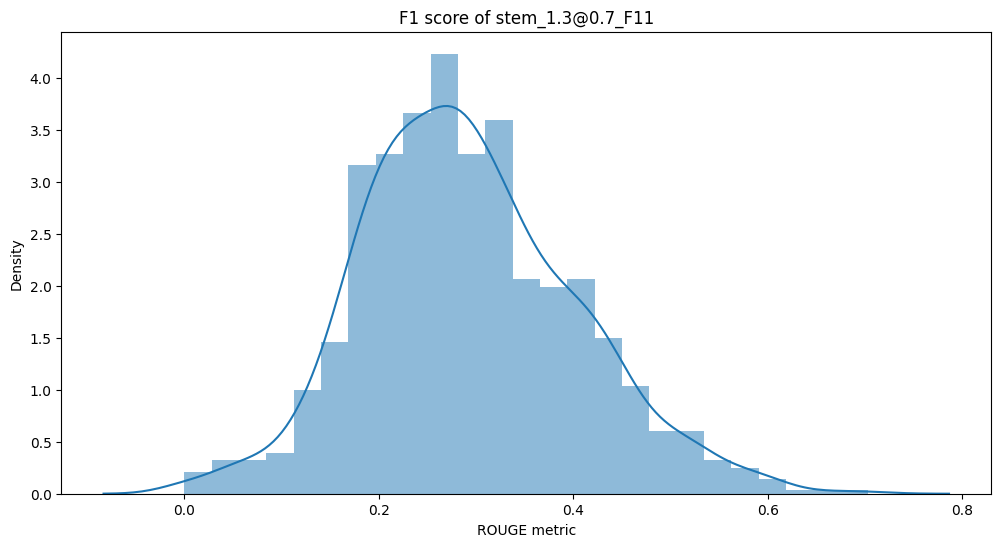

In [60]:
score_column = 'stem_1.3@0.7_F1'
# print('F1 average = {:.4f}'.format(predictions_scores[score_column].max()))
# print('F1 standard deviation = {:.4f}'.format(predictions_scores[score_column].std()))


_, ax = plt.subplots(figsize = (12,6))
sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)
ax.set_xlabel('ROUGE metric')
ax.set_title('F1 score of stem_1.3@0.7_F11')

### Difference of number of sentences between hypothesis and reference

In [61]:
def len_sent_tokenize(text):
  return len(sentence_tokenize(text))



qty_of_sentences = predictions_test['stem_1.3@0.7'].apply(len_sent_tokenize)

In [62]:
qty_of_sentences_reference = predictions_test['reference'].apply(len_sent_tokenize)

diff_number_of_sentences = qty_of_sentences - qty_of_sentences_reference



In [63]:
print(diff_number_of_sentences)
print("Max Difference",np.max(diff_number_of_sentences))
print("Minimum Difference",np.min(diff_number_of_sentences))


0       -5
90      -1
181     -1
272     -1
363     -1
        ..
90243   -1
90333   -1
90424   -2
90514    0
90604   -3
Length: 1000, dtype: int64
Max Difference 7
Minimum Difference -8


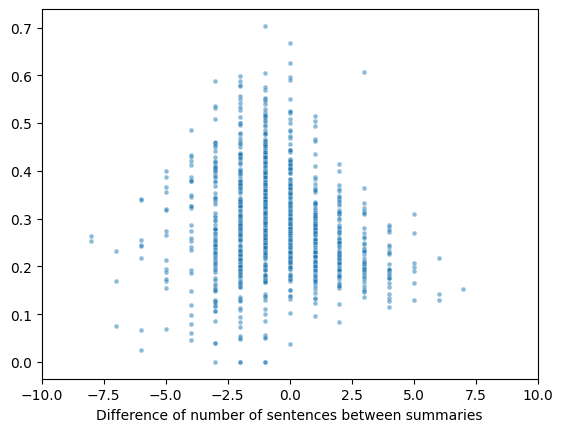

In [64]:
sns.scatterplot(x = diff_number_of_sentences, 
            y = predictions_scores['stem_1.3@0.7_F1'].values,
            alpha =0.5, s = 12)

plt.xlabel('Difference of number of sentences between summaries')
plt.xlim((-10,+10))
plt.show()